In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

import torch

from pathlib import Path
from models.unet import *
from utils.plot import *
from utils.data_loader import *

In [3]:
CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\studies\CT-1")
MASK_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\masks")

In [4]:
ds = CTSlices(CT_DIR, MASK_DIR)

In [5]:
model = UNet(n_channels=1, kernel_size=3, ds=1).cuda()

In [6]:
dataloader = DataLoader(
    ds, 
    batch_size=2,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [7]:
N_EPOCHS = 500
learning_rate = 1e-4
WEIGHT_DIR = Path("weights")
if not WEIGHT_DIR.exists():
    WEIGHT_DIR.mkdir(parents=True)

In [8]:
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=learning_rate,
    total_steps=N_EPOCHS * len(dataloader),
    cycle_momentum=True,
)

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return -(numerator + 1) / (denominator + 1)

loss_obj = dice_loss

  0%|▏                                                                 | 1/500 [00:35<4:56:09, 35.61s/it, loss=-0.0086]

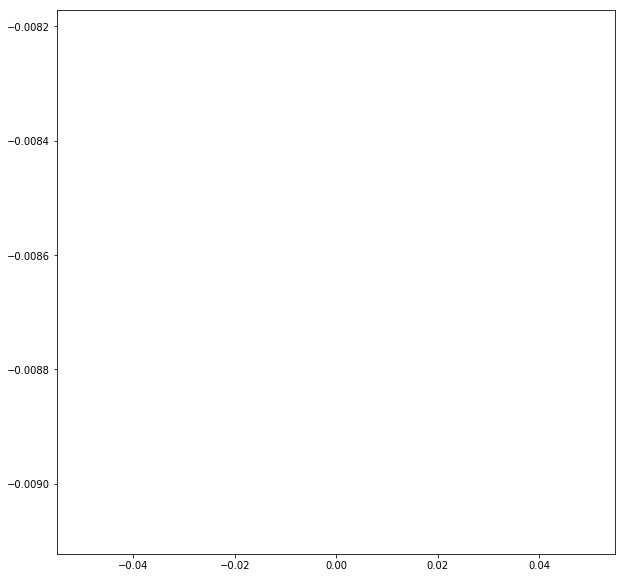

  2%|█▍                                                               | 11/500 [06:23<4:42:37, 34.68s/it, loss=-0.0091]

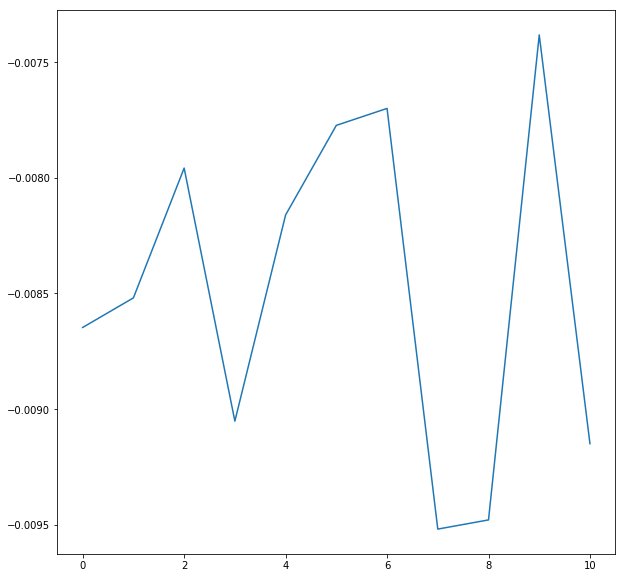

  4%|██▋                                                              | 21/500 [12:14<4:37:28, 34.76s/it, loss=-0.0119]

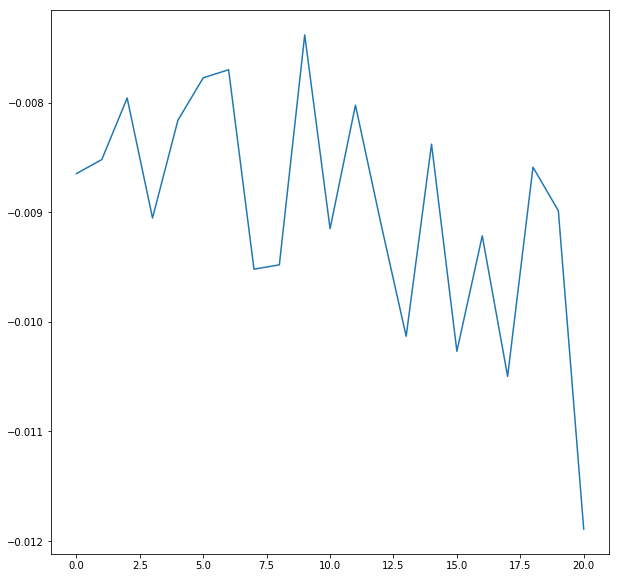

  6%|████                                                             | 31/500 [18:05<4:31:57, 34.79s/it, loss=-0.4641]

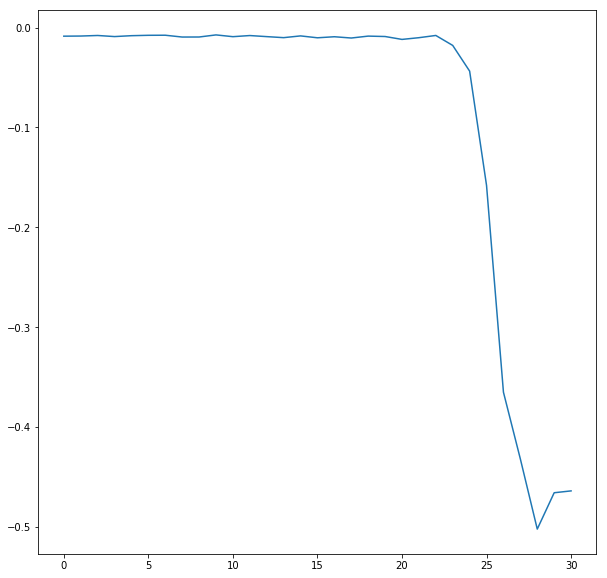

  8%|█████▎                                                           | 41/500 [23:56<4:26:05, 34.78s/it, loss=-0.4215]

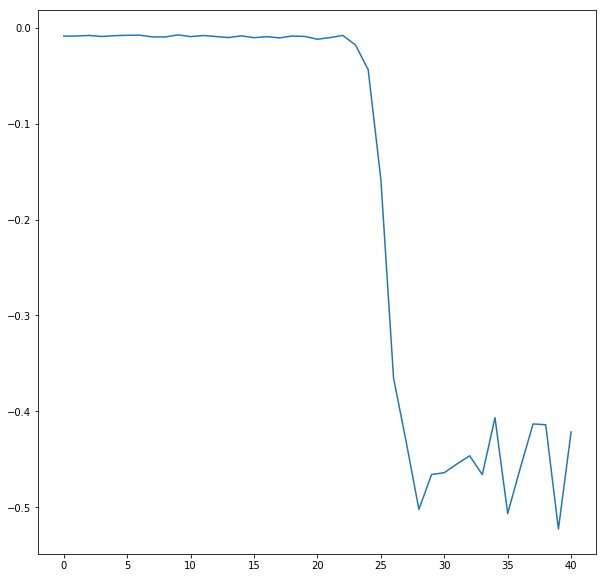

 10%|██████▋                                                          | 51/500 [29:48<4:20:11, 34.77s/it, loss=-0.4985]

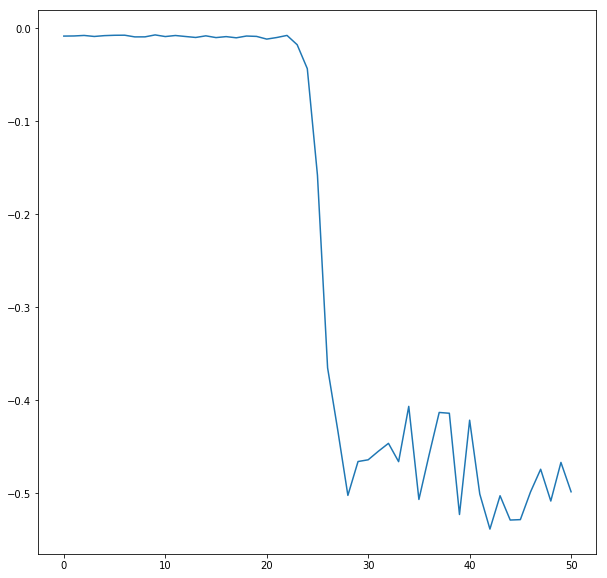

 12%|███████▉                                                         | 61/500 [35:38<4:13:59, 34.71s/it, loss=-0.5386]

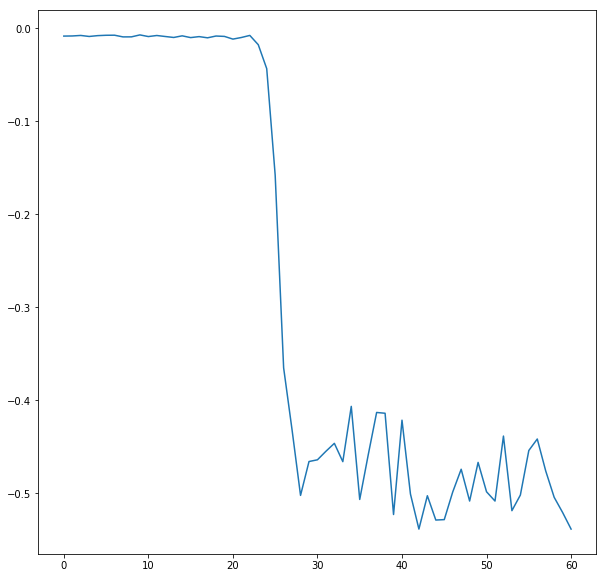

 14%|█████████▏                                                       | 71/500 [41:29<4:08:03, 34.69s/it, loss=-0.4812]

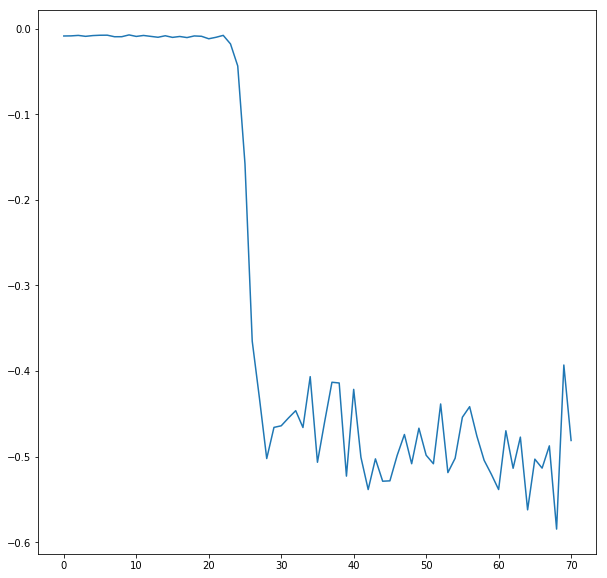

 16%|██████████▌                                                      | 81/500 [47:20<4:02:21, 34.71s/it, loss=-0.4651]

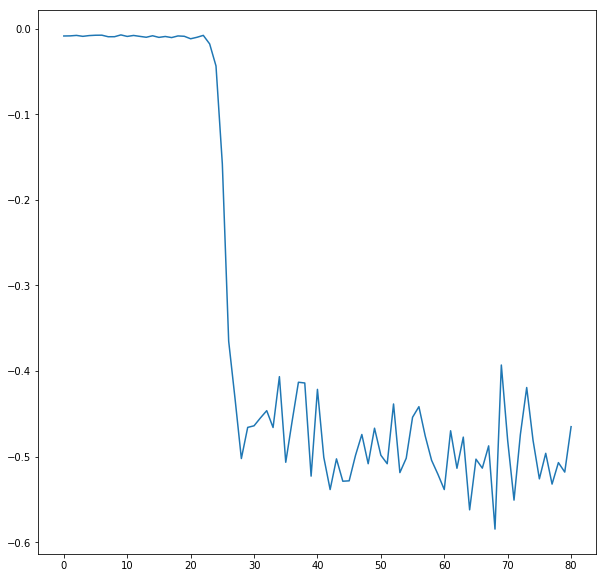

 18%|███████████▊                                                     | 91/500 [53:10<3:56:34, 34.70s/it, loss=-0.5757]

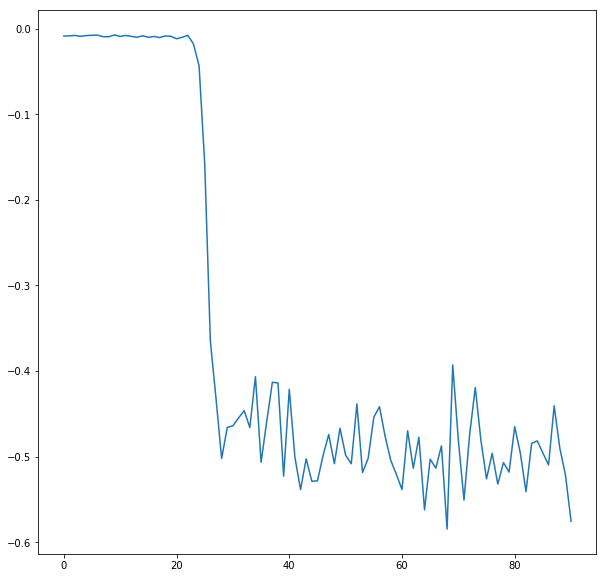

 20%|████████████▉                                                   | 101/500 [59:01<3:50:51, 34.72s/it, loss=-0.5305]

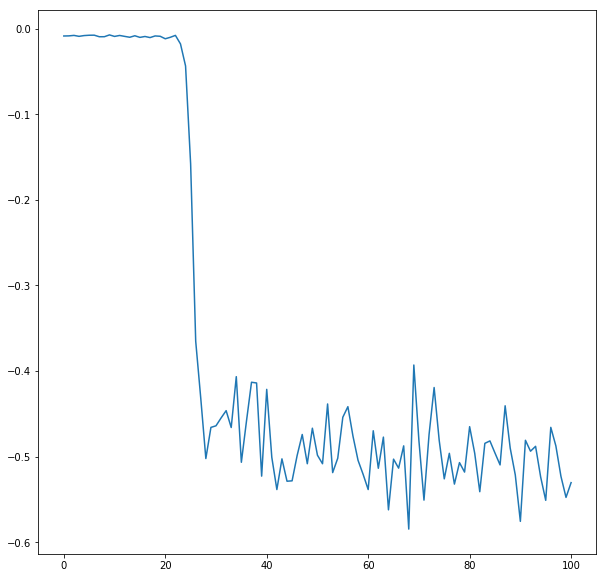

 22%|█████████████▊                                                | 111/500 [1:04:51<3:44:43, 34.66s/it, loss=-0.5027]

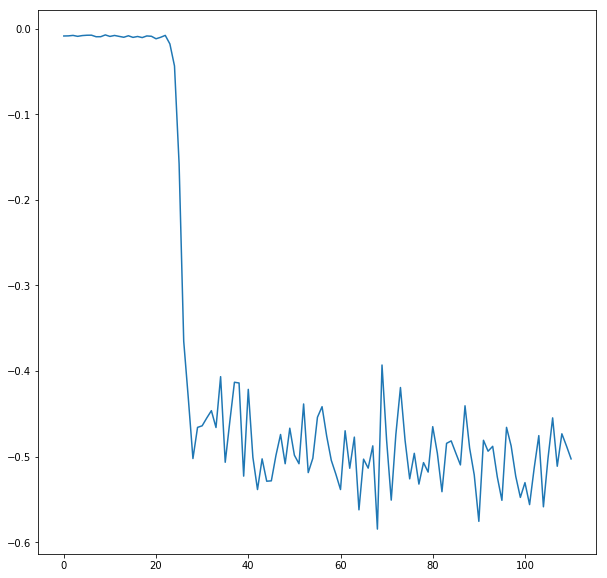

 24%|███████████████                                               | 121/500 [1:10:40<3:38:41, 34.62s/it, loss=-0.5247]

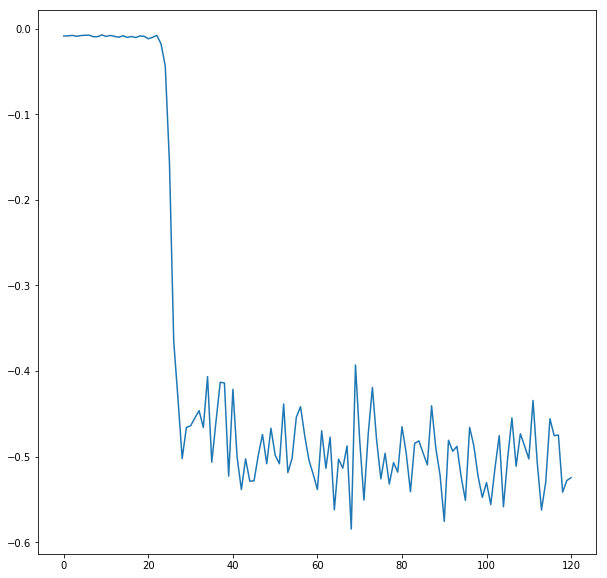

 26%|████████████████▏                                             | 131/500 [1:16:31<3:33:09, 34.66s/it, loss=-0.4766]

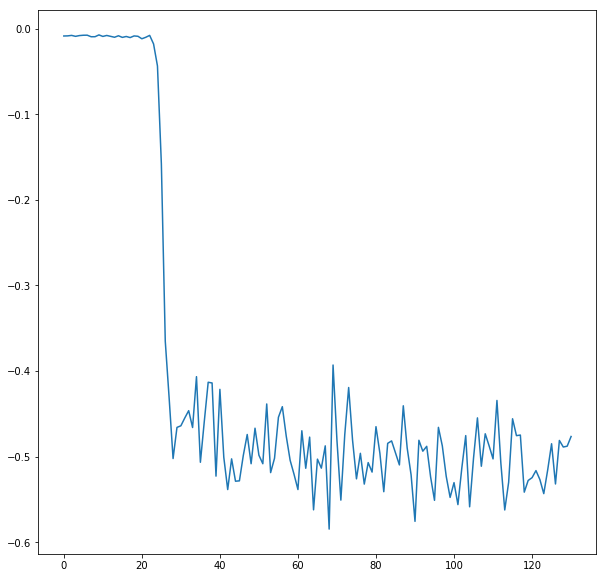

 28%|█████████████████▍                                            | 141/500 [1:22:14<3:24:45, 34.22s/it, loss=-0.5614]

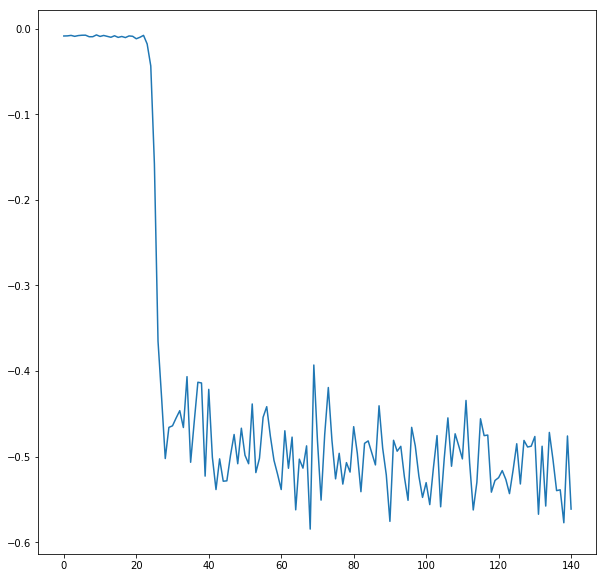

 30%|██████████████████▋                                           | 151/500 [1:27:59<3:18:55, 34.20s/it, loss=-0.4502]

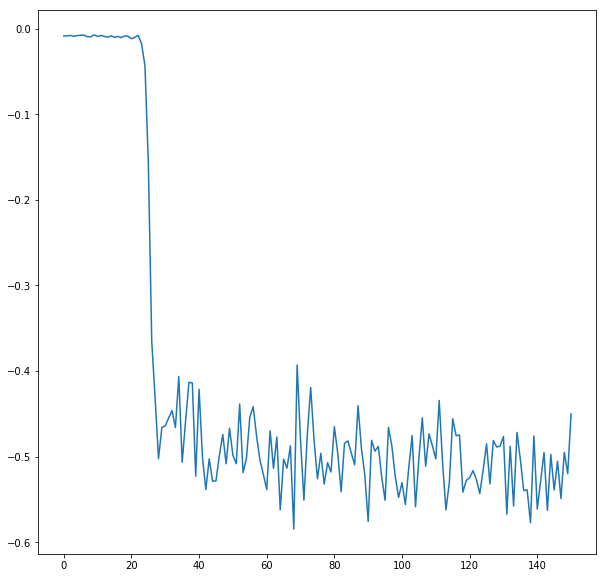

 32%|███████████████████▉                                          | 161/500 [1:33:45<3:13:26, 34.24s/it, loss=-0.5613]

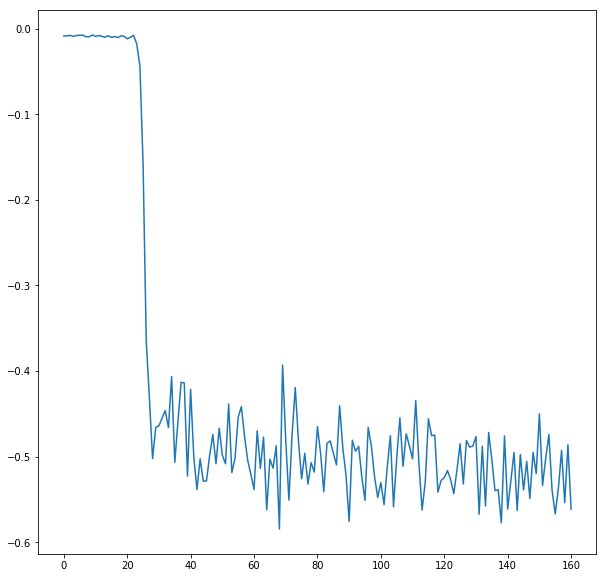

 34%|█████████████████████▏                                        | 171/500 [1:39:32<3:08:52, 34.44s/it, loss=-0.5184]

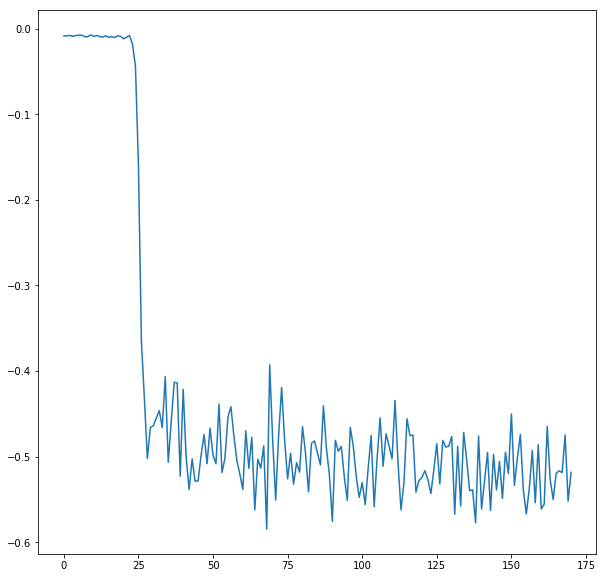

 36%|██████████████████████▍                                       | 181/500 [1:45:21<3:03:38, 34.54s/it, loss=-0.4426]

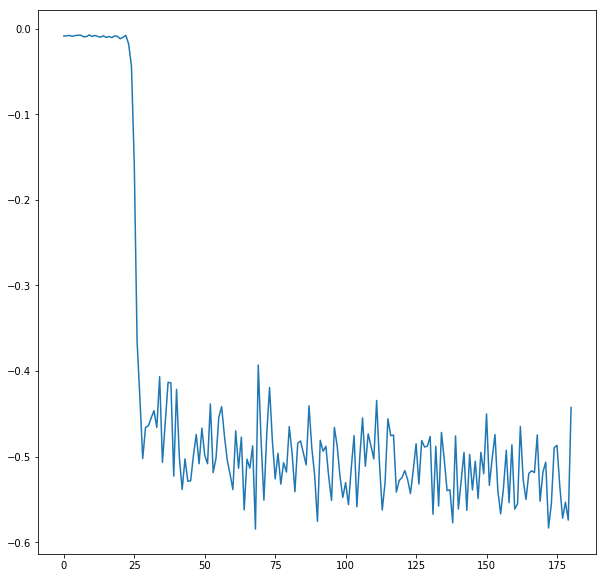

 38%|███████████████████████▋                                      | 191/500 [1:51:10<2:57:58, 34.56s/it, loss=-0.3573]

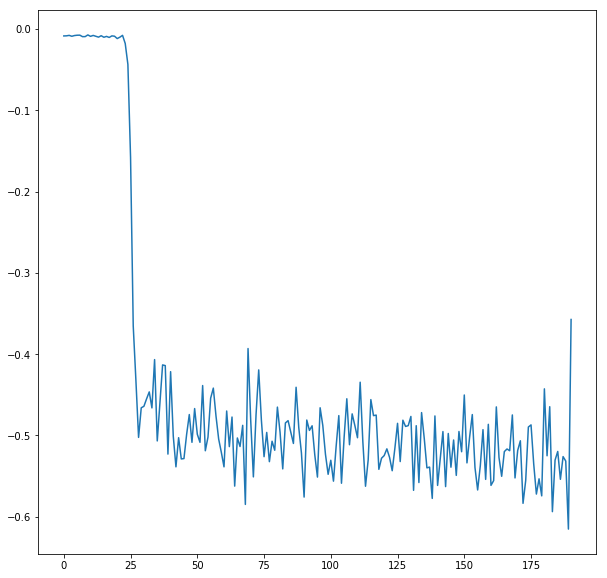

 40%|████████████████████████▉                                     | 201/500 [1:57:00<2:52:23, 34.59s/it, loss=-0.4953]

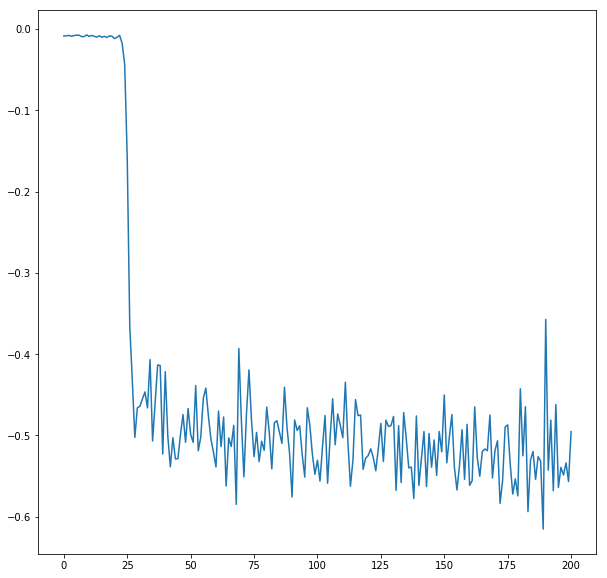

 42%|██████████████████████████▏                                   | 211/500 [2:02:47<2:45:38, 34.39s/it, loss=-0.5564]

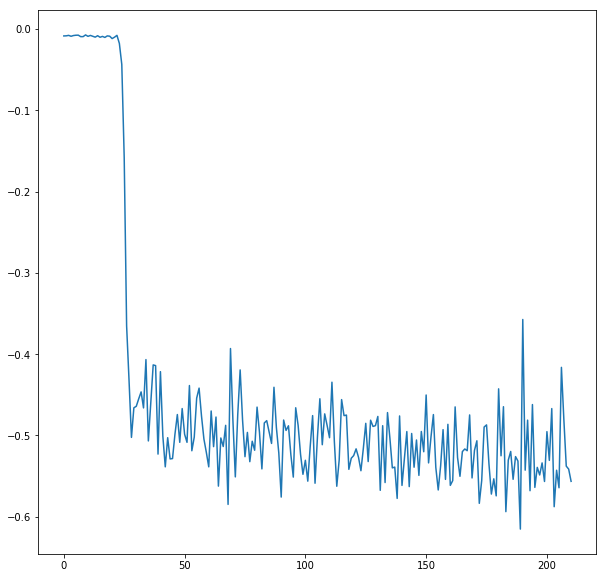

 44%|███████████████████████████▍                                  | 221/500 [2:08:35<2:40:38, 34.55s/it, loss=-0.5370]

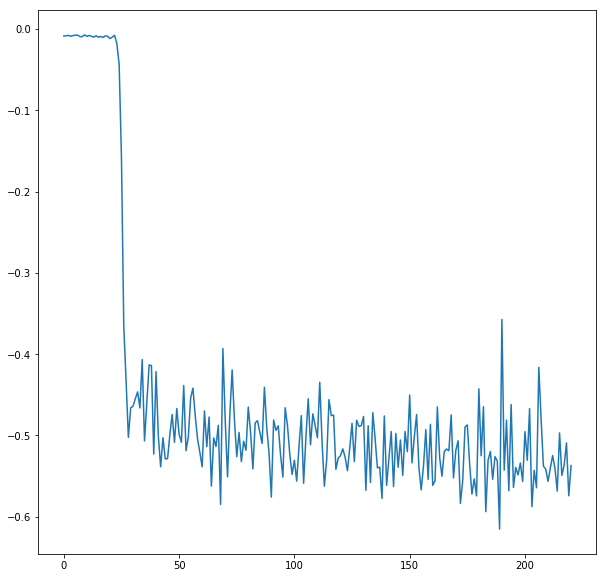

 46%|████████████████████████████▋                                 | 231/500 [2:14:25<2:35:15, 34.63s/it, loss=-0.5270]

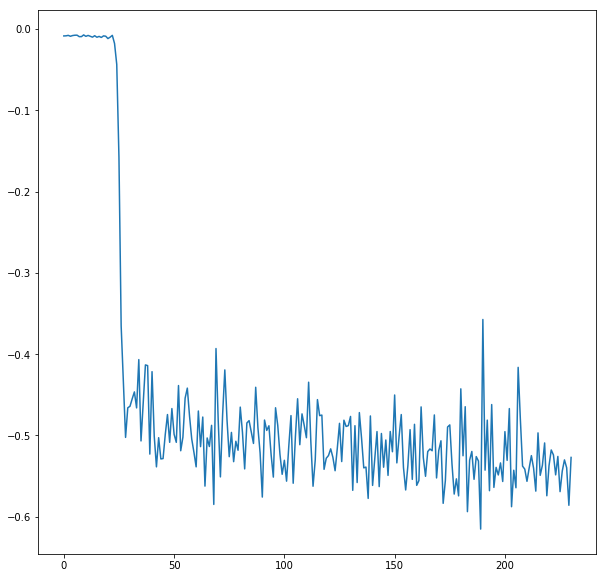

 48%|█████████████████████████████▉                                | 241/500 [2:20:15<2:29:32, 34.64s/it, loss=-0.4989]

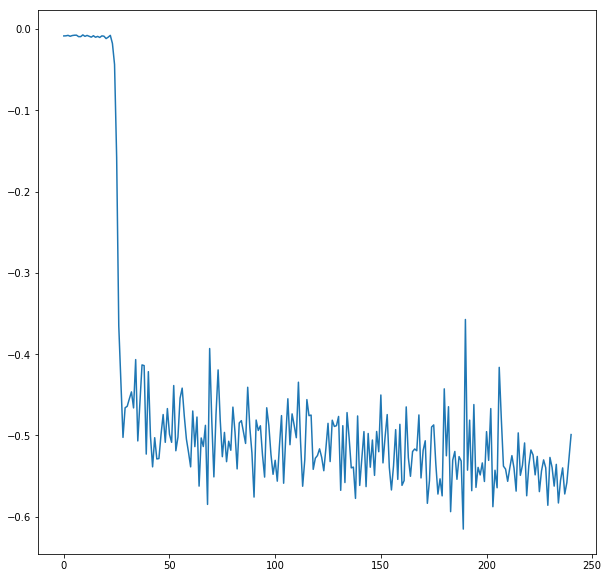

 50%|███████████████████████████████                               | 251/500 [2:26:05<2:23:38, 34.61s/it, loss=-0.5818]

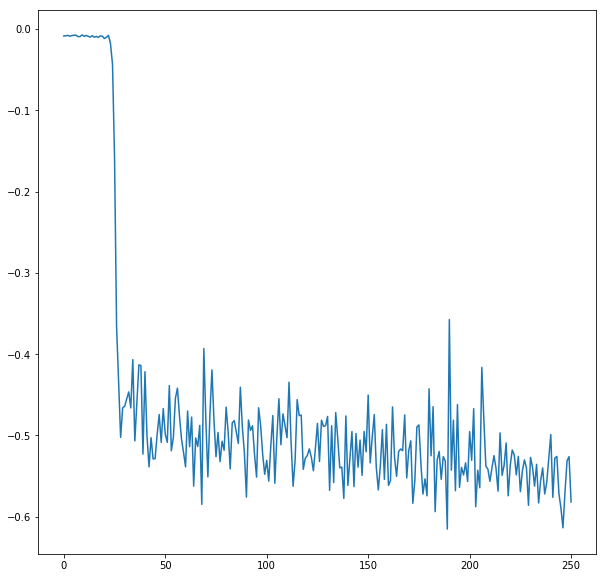

 52%|████████████████████████████████▎                             | 261/500 [2:31:54<2:17:47, 34.59s/it, loss=-0.5474]

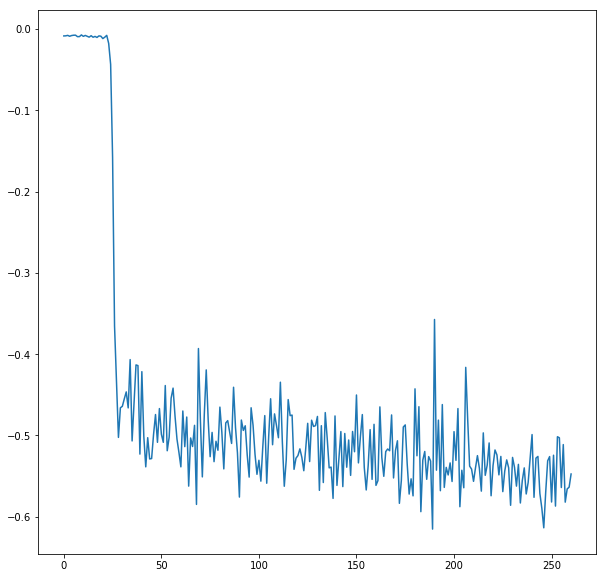

 54%|█████████████████████████████████▌                            | 271/500 [2:37:43<2:12:09, 34.63s/it, loss=-0.5321]

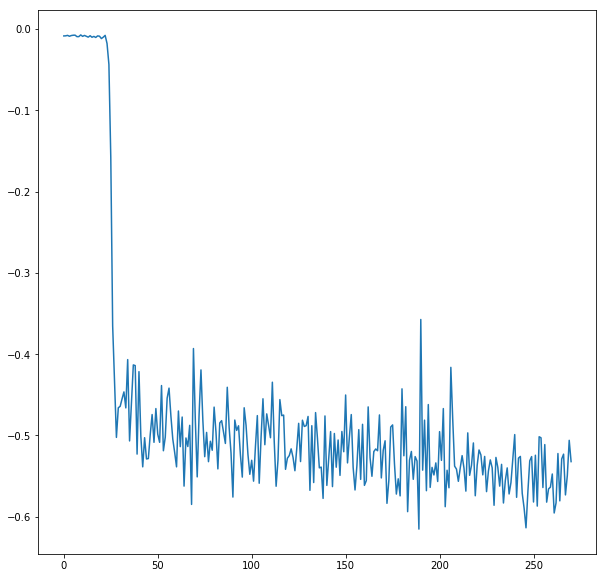

 56%|██████████████████████████████████▊                           | 281/500 [2:43:32<2:06:22, 34.62s/it, loss=-0.6213]

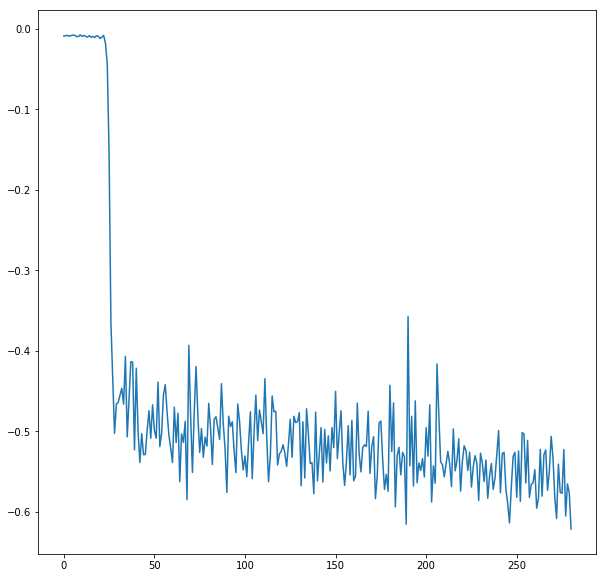

 58%|████████████████████████████████████                          | 291/500 [2:49:21<2:00:23, 34.56s/it, loss=-0.5050]

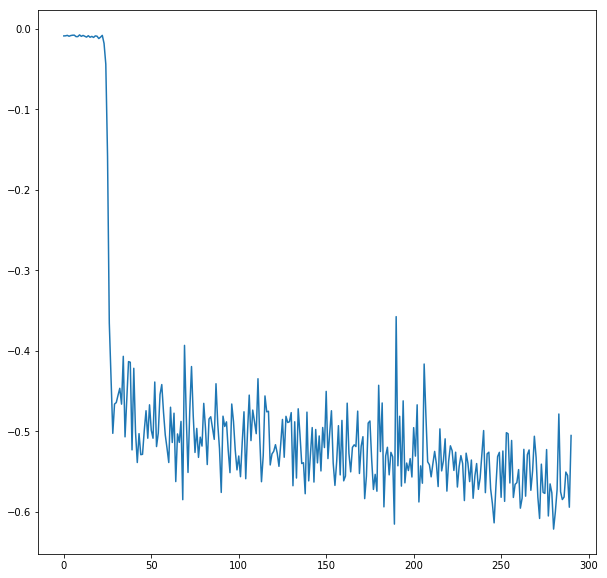

 60%|█████████████████████████████████████▎                        | 301/500 [2:55:11<1:54:36, 34.56s/it, loss=-0.5427]

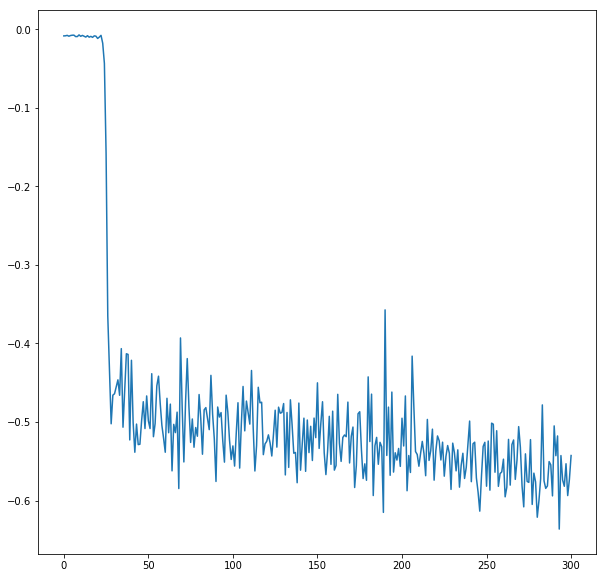

 62%|██████████████████████████████████████▌                       | 311/500 [3:01:01<1:49:12, 34.67s/it, loss=-0.5971]

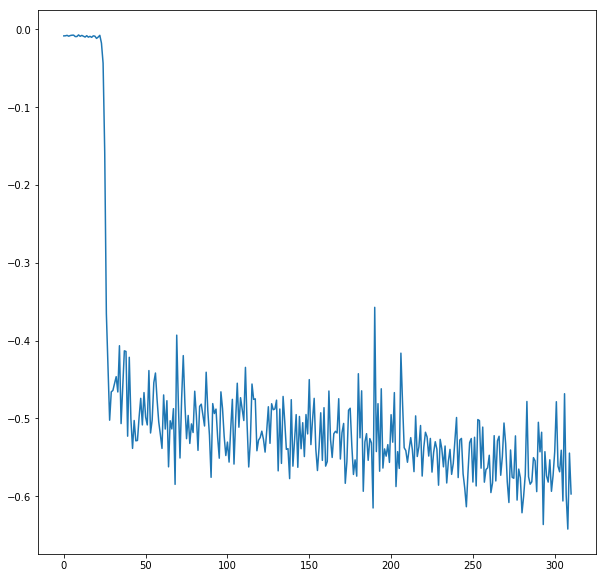

 64%|███████████████████████████████████████▊                      | 321/500 [3:06:51<1:43:21, 34.64s/it, loss=-0.4994]

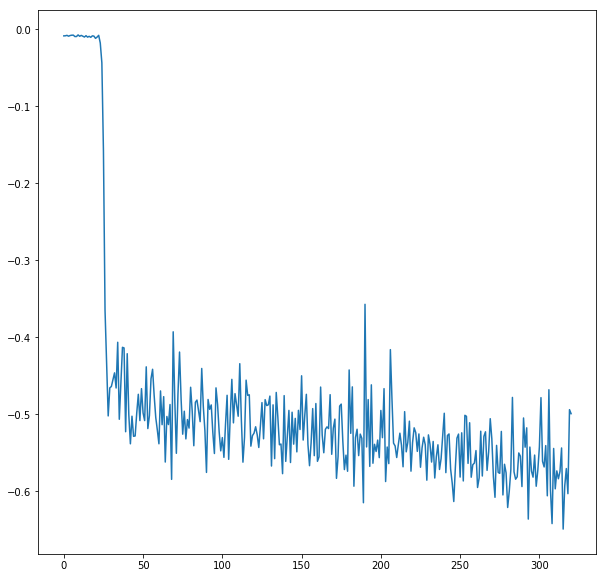

 66%|█████████████████████████████████████████                     | 331/500 [3:12:41<1:37:38, 34.66s/it, loss=-0.5676]

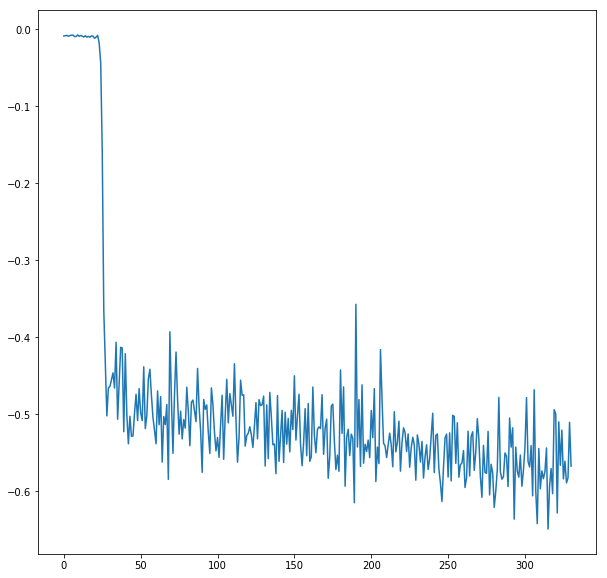

 68%|██████████████████████████████████████████▎                   | 341/500 [3:18:31<1:31:49, 34.65s/it, loss=-0.5538]

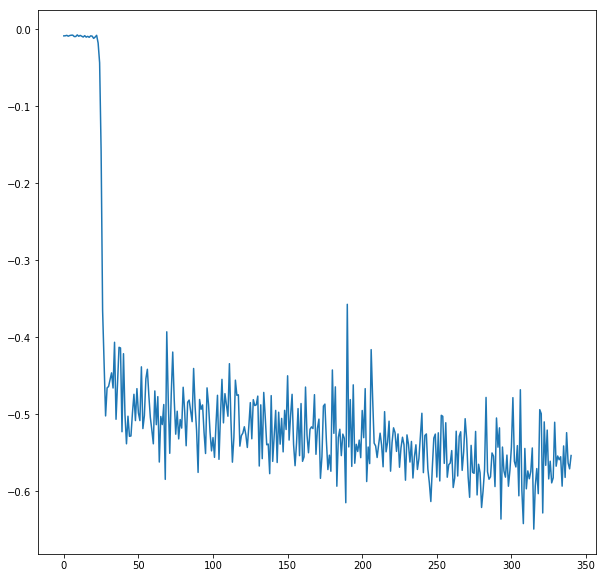

 70%|███████████████████████████████████████████▌                  | 351/500 [3:24:21<1:25:58, 34.62s/it, loss=-0.6196]

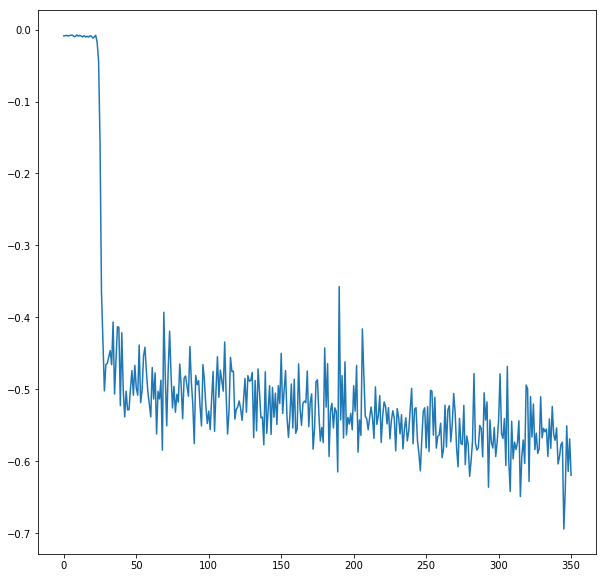

 72%|████████████████████████████████████████████▊                 | 361/500 [3:30:11<1:20:12, 34.62s/it, loss=-0.5475]

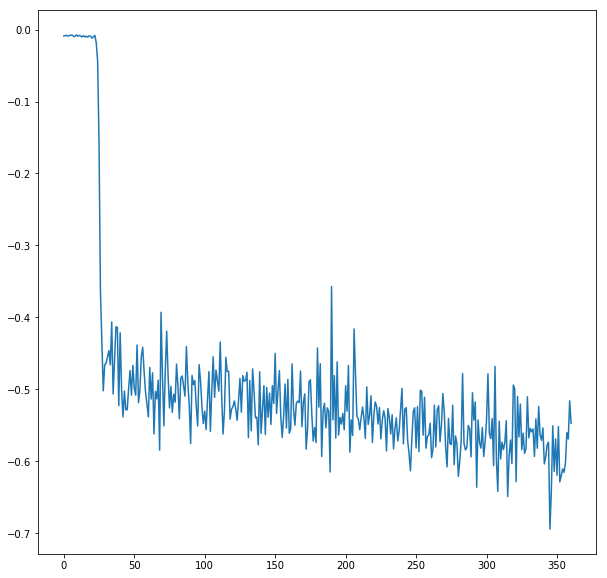

 74%|██████████████████████████████████████████████                | 371/500 [3:36:01<1:14:25, 34.62s/it, loss=-0.5555]

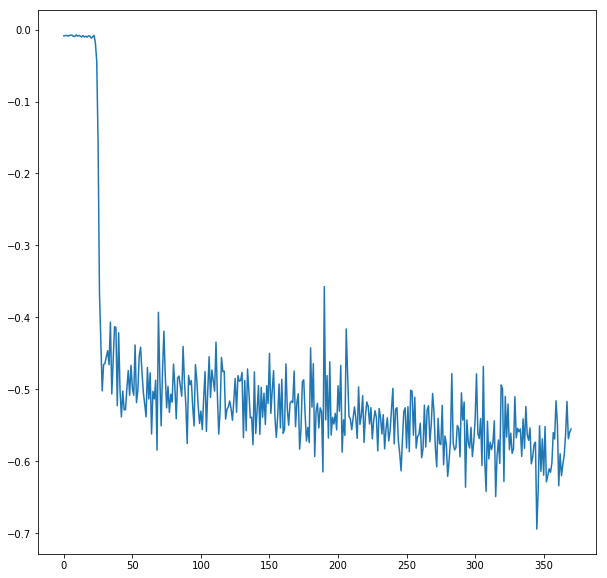

 76%|███████████████████████████████████████████████▏              | 381/500 [3:41:50<1:08:41, 34.64s/it, loss=-0.6153]

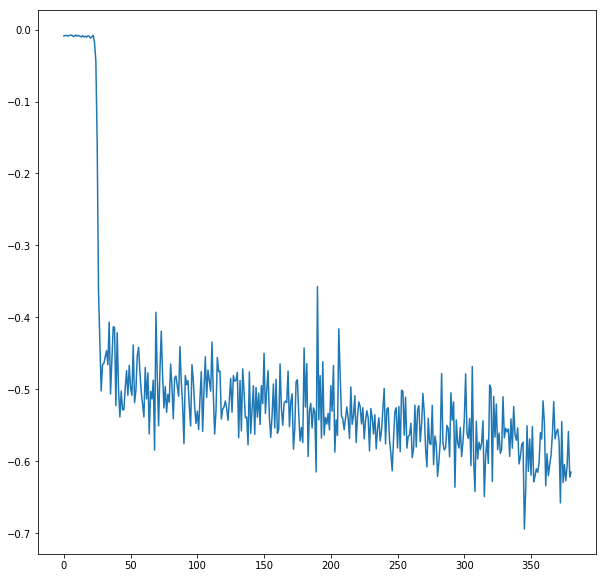

 78%|████████████████████████████████████████████████▍             | 391/500 [3:47:39<1:02:53, 34.62s/it, loss=-0.5844]

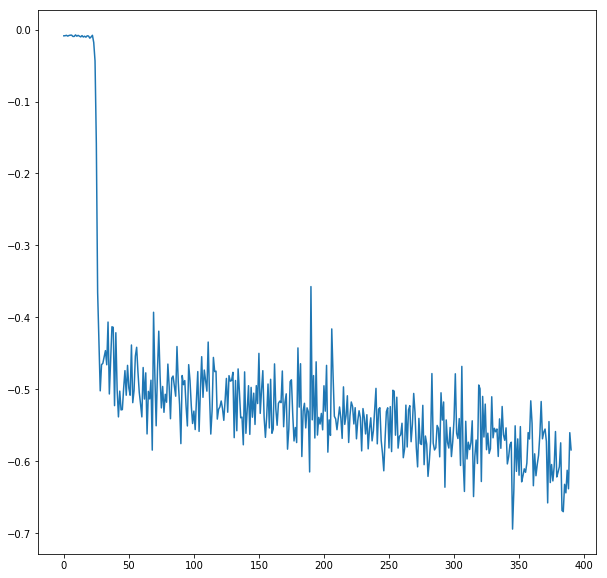

 80%|███████████████████████████████████████████████████▎            | 401/500 [3:53:28<56:56, 34.51s/it, loss=-0.5897]

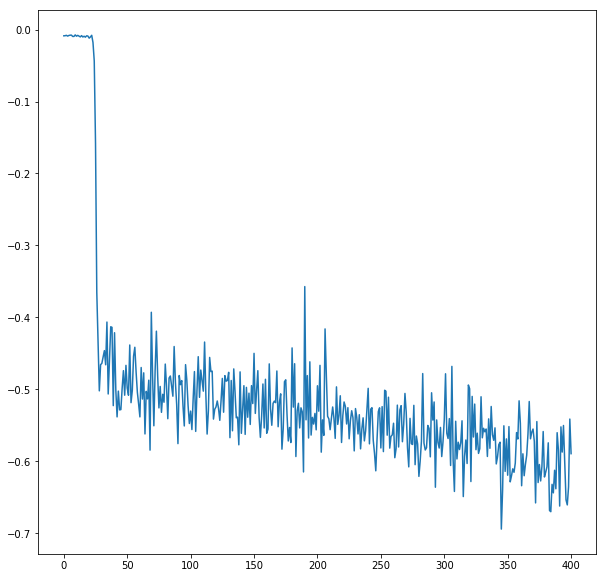

 82%|████████████████████████████████████████████████████▌           | 411/500 [3:59:15<50:55, 34.34s/it, loss=-0.6299]

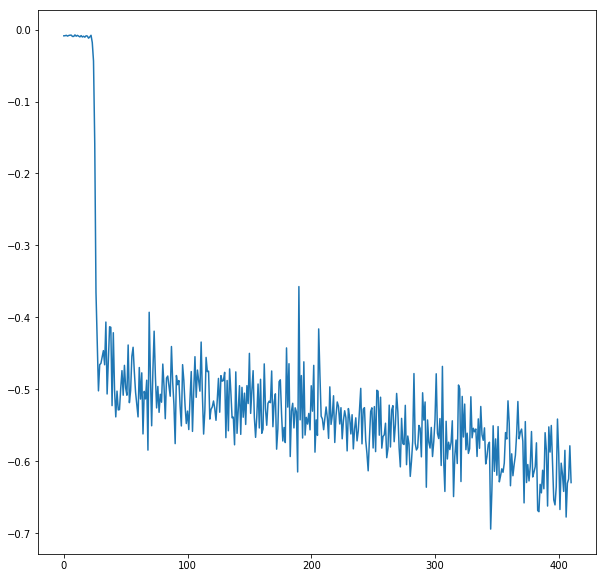

 84%|█████████████████████████████████████████████████████▉          | 421/500 [4:05:01<45:13, 34.34s/it, loss=-0.6657]

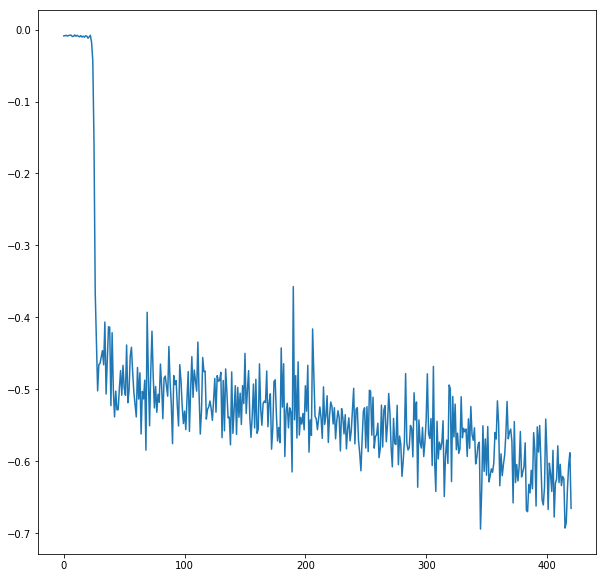

 86%|███████████████████████████████████████████████████████▏        | 431/500 [4:10:48<39:29, 34.34s/it, loss=-0.6571]

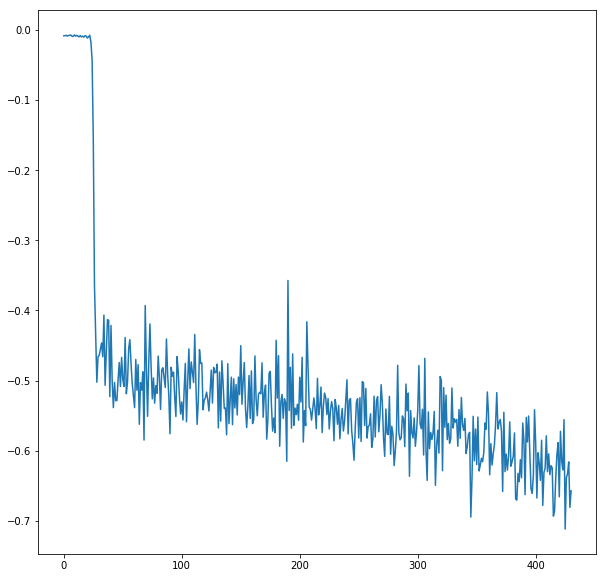

 88%|████████████████████████████████████████████████████████▍       | 441/500 [4:16:36<33:53, 34.47s/it, loss=-0.6273]

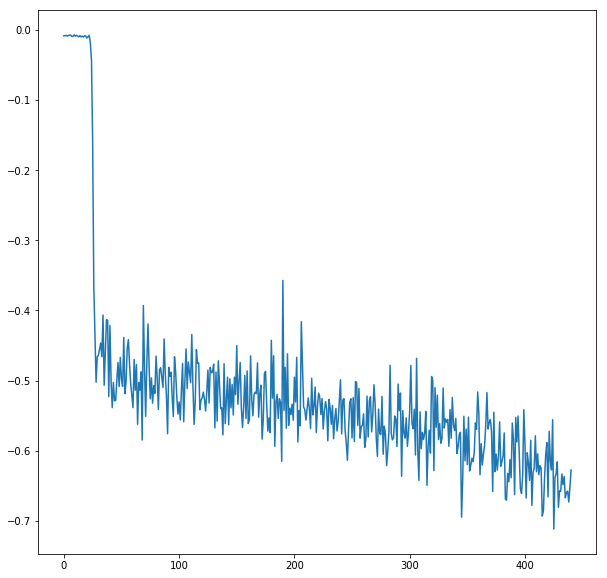

 90%|█████████████████████████████████████████████████████████▋      | 451/500 [4:22:25<28:13, 34.57s/it, loss=-0.6510]

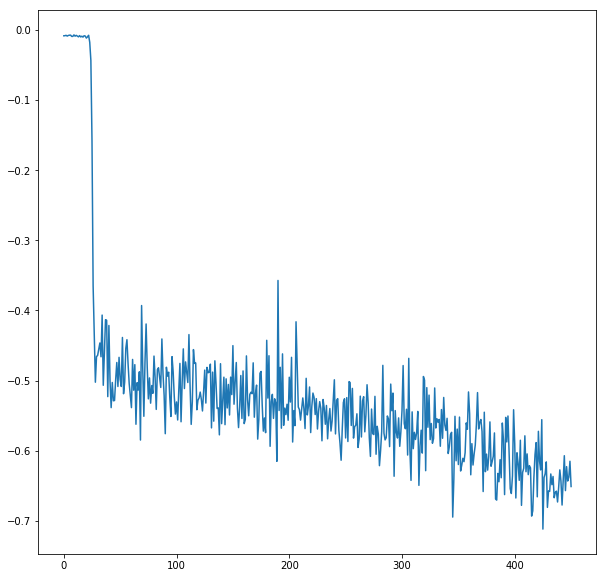

 92%|███████████████████████████████████████████████████████████     | 461/500 [4:28:15<22:29, 34.61s/it, loss=-0.6785]

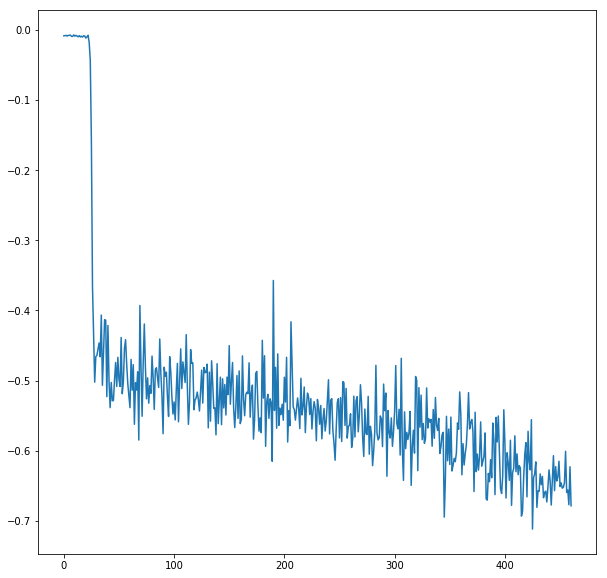

 94%|████████████████████████████████████████████████████████████▎   | 471/500 [4:34:05<16:43, 34.62s/it, loss=-0.6446]

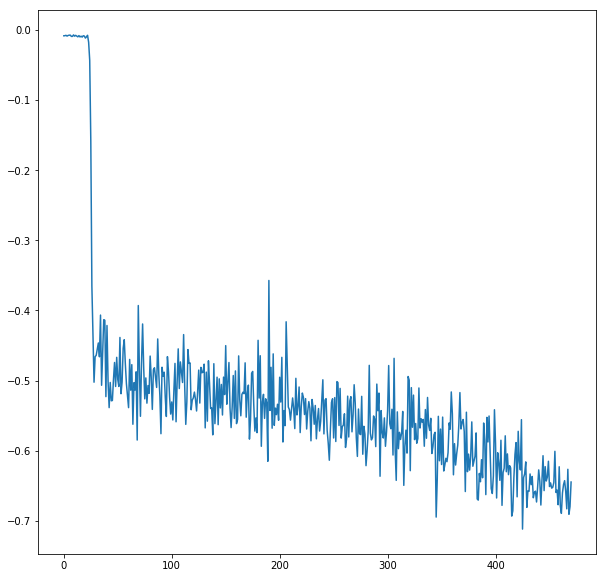

 96%|█████████████████████████████████████████████████████████████▌  | 481/500 [4:39:54<10:56, 34.55s/it, loss=-0.6625]

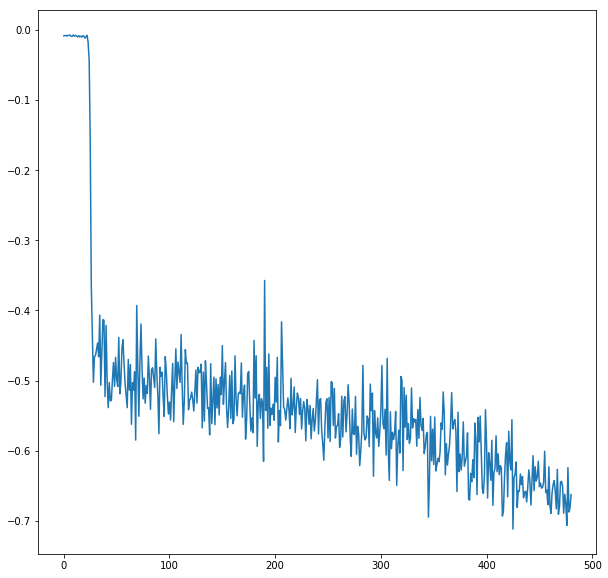

 98%|██████████████████████████████████████████████████████████████▊ | 491/500 [4:45:42<05:11, 34.58s/it, loss=-0.7077]

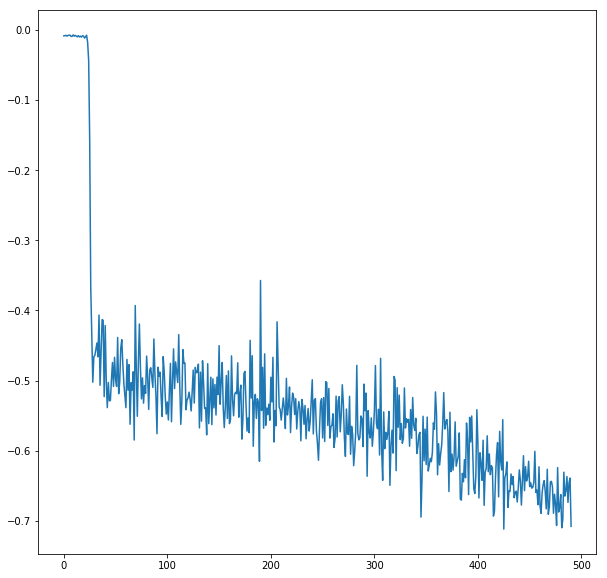

100%|████████████████████████████████████████████████████████████████| 500/500 [4:50:58<00:00, 34.92s/it, loss=-0.6080]


In [9]:
losses = []
with tqdm(total=N_EPOCHS) as pbar:
    for cur_epoch in range(N_EPOCHS):
        epoch_loss = 0

        for xs, ys in dataloader:
            opt.zero_grad()
            
            ys_hat = model(xs)
            loss = dice_loss(ys_hat, ys)
            loss.backward()
            opt.step()
            scheduler.step()
            
            epoch_loss += loss.detach().cpu().numpy()
            
        # Progress bar update

        losses.append(epoch_loss / len(dataloader))

        pbar.set_postfix(
            {
                'loss': '{:.4f}'.format(losses[-1]),
#                 'cur_lr': scheduler.get_last_lr()[0],
            }
        )
        pbar.update(1)

        if cur_epoch % 10 == 0:
            plt.plot(losses)
            plt.show()

            WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch)
            torch.save(
                {
                    'model': model.state_dict(),
                    'opt': opt.state_dict(),
                },
                str(WEIGHT_PATH),
            )

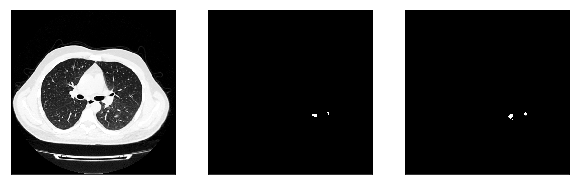

In [11]:
multiplot([
    xs[0,0].detach().cpu().numpy(),
    ys[0,0].detach().cpu().numpy(),
    ys_hat[0,0].detach().cpu().numpy(),
])

In [12]:
cur_epoch


499

In [14]:
WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch+1)
torch.save(
    {
        'model': model.state_dict(),
        'opt': opt.state_dict(),
    },
    str(WEIGHT_PATH),
)